In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import morphs
from morphs.data.derivative import f_map

from sklearn.model_selection import LeaveOneGroupOut, cross_validate

logo = LeaveOneGroupOut()
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

from xgboost import XGBClassifier

xgb = XGBClassifier()

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
ddf = morphs.load.derivative_df()
dd = morphs.load.derivative_dict()
max_order = morphs.data.derivative.find_max_order(dd)

In [3]:
def cv_morph_dim_prediction(ddf, discriminator, eval_f=True):
    scores = {}
    for order in range(max_order + 1):
        xs = ddf[order][ddf[order].str[0].notna()]
        if eval_f:
            xs = xs.map(f_map)
        xs = np.array([x for x in xs.values])
        labels = ddf["morph_dim"][ddf[order].str[0].notna()].values
        groups = ddf["block_path"][ddf[order].str[0].notna()].values
        cv_scores = cross_validate(
            discriminator, xs, y=labels, cv=logo.split(xs, labels, groups), n_jobs=-1
        )
        scores[order] = cv_scores["test_score"].mean()
    return scores

In [4]:
# NBVAL_SKIP
mean_scores = cv_morph_dim_prediction(ddf, lr)

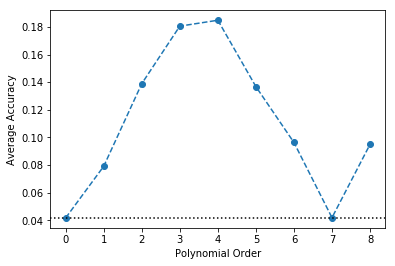

In [5]:
# NBVAL_SKIP
ax = plt.gca()
_ = ax.plot(range(max_order + 1), [mean_scores[order] for order in range(max_order + 1)], "o--")
_ = ax.axhline(1 / 24, linestyle=":", color="k")
_ = ax.set_ylabel("Average Accuracy")
_ = ax.set_xlabel("Polynomial Order")

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
# NBVAL_SKIP
xgb_mean_scores = cv_morph_dim_prediction(ddf, xgb)

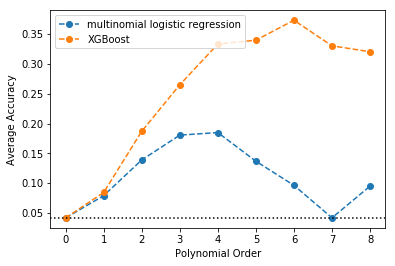

In [8]:
# NBVAL_SKIP
ax = plt.gca()
_ = ax.plot(
    range(max_order + 1),
    [mean_scores[order] for order in range(max_order + 1)],
    "o--",
    label="multinomial logistic regression",
)
_ = ax.plot(
    range(max_order + 1),
    [xgb_mean_scores[order] for order in range(max_order + 1)],
    "o--",
    label="XGBoost",
)
_ = ax.axhline(1 / 24, linestyle=":", color="k")
_ = ax.set_ylabel("Average Accuracy")
_ = ax.set_xlabel("Polynomial Order")
_ = ax.legend()

In [9]:
# NBVAL_SKIP
mean_popt_scores = cv_morph_dim_prediction(ddf, lr, eval_f=False)

In [10]:
# NBVAL_SKIP
xgb_mean_popt_scores = cv_morph_dim_prediction(ddf, xgb, eval_f=False)

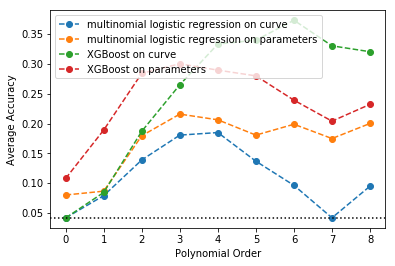

In [11]:
# NBVAL_SKIP
ax = plt.gca()
_ = ax.plot(
    range(max_order + 1),
    [mean_scores[order] for order in range(max_order + 1)],
    "o--",
    label="multinomial logistic regression on curve",
)
_ = ax.plot(
    range(max_order + 1),
    [mean_popt_scores[order] for order in range(max_order + 1)],
    "o--",
    label="multinomial logistic regression on parameters",
)
_ = ax.plot(
    range(max_order + 1),
    [xgb_mean_scores[order] for order in range(max_order + 1)],
    "o--",
    label="XGBoost on curve",
)
_ = ax.plot(
    range(max_order + 1),
    [xgb_mean_popt_scores[order] for order in range(max_order + 1)],
    "o--",
    label="XGBoost on parameters",
)
_ = ax.axhline(1 / 24, linestyle=":", color="k")
_ = ax.set_ylabel("Average Accuracy")
_ = ax.set_xlabel("Polynomial Order")
_ = ax.legend()

Multinomial logistic regression seems to perform better on the parameters than the evaluated function. However, xgboost is able to extract more structure from evaluated higher order Thielk curves. This is likely due to me normalizing the total integral to 1 when evaluated.